In [17]:
import torch
from torch.utils.data import Dataset, Subset,DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import nibabel as nib
from pathlib import Path
import numpy as np
from typing import Tuple
import torch.nn as nn
from tqdm import tqdm
from collections import Counter
from models.resnet import resnet10
import albumentations as A
import torch.nn.functional as F
import torchio as tio
from sklearn.model_selection import GroupKFold
import torch.nn as nn
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Data shape: torch.Size([4, 1, 32, 256, 256])
Labels shape: torch.Size([4])


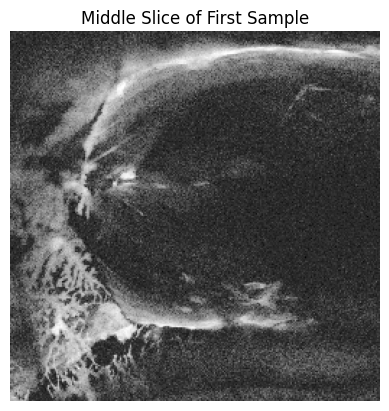

In [18]:
class CustomDataset(Dataset):  
    def __init__(self, txt_file, base_dir=Path("."), transform=None, fixed_depth=32):
        self.paths = []
        self.transform = transform
        self.fixed_depth = fixed_depth

        with open(txt_file, "r") as f:
            for line in f:
                relative_path, label = line.strip().split()
                full_path = base_dir / relative_path
                self.paths.append((full_path, int(label)))

    def __getitem__(self, idx):
        file_path, label = self.paths[idx]
        zstack = nib.load(file_path)
        data = zstack.get_fdata().astype(np.float32)

        # Log normalization + Min-Max
        data = np.log1p(data)
        data_min, data_max = data.min(), data.max()
        data = (data - data_min) / (data_max - data_min) if data_max > data_min else np.zeros_like(data)

        # --- Padding or Cropping Depth (D) ---
        current_depth = data.shape[0]
        if current_depth < self.fixed_depth:
            pad_front = (self.fixed_depth - current_depth) // 2
            pad_back = self.fixed_depth - current_depth - pad_front
            data = np.pad(data, ((pad_front, pad_back), (0, 0), (0, 0)), mode='constant', constant_values=0)
        elif current_depth > self.fixed_depth:
            start = (current_depth - self.fixed_depth) // 2
            data = data[start:start + self.fixed_depth, :, :]

        data = torch.tensor(data).unsqueeze(0)

        if self.transform:
            subject = self.transform(subject)
            data = subject['image'].data

        # Resize height & width 
        data = F.interpolate(
            data.unsqueeze(0), size=(self.fixed_depth, 256, 256),
            mode='trilinear', align_corners=False
        ).squeeze(0)

        label = torch.tensor(label, dtype=torch.float32)
        return data, label

    def __len__(self):
        return len(self.paths)

dataset = CustomDataset( txt_file="data/ZStacksWTMUT/ALLL.txt",  base_dir=Path("data/"),transform=None)
loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)


batch = next(iter(loader))
data, labels = batch

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

import matplotlib.pyplot as plt


sample = data[0] 
slice_idx = sample.shape[1] // 2  # Middle slice in depth dimension (32 // 2 = 16)


slice_img = sample[0, slice_idx, :, :].numpy()

plt.imshow(slice_img, cmap='gray')
plt.title("Middle Slice of First Sample")
plt.axis('off')
plt.show()

Class 1: 714 (50.85%)
Class 0: 690 (49.15%)


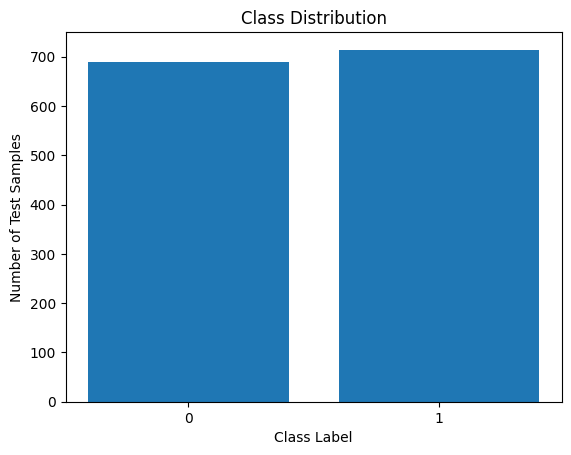

In [ ]:
dataset = CustomDataset(txt_file="data/ZStacksWTMUT/ALLL.txt",  base_dir=Path("data/"),transform=None) # ALLL.txt is where I stored the original and its augmented versions paths

y = [label for _,label in original_dataset.paths] 
X = [path for path,label in original_dataset.paths] 

class_counts = Counter(y)
total = sum(class_counts.values())
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} ({count / total:.2%})")

plt.bar(class_counts.keys(), class_counts.values())
plt.xticks([0, 1])
plt.xlabel("Class Label")
plt.ylabel("Number of Test Samples")
plt.title("Class Distribution")
plt.show()

In [10]:
# MODEL ARCHITECTURE: 

from models.resnet import resnet10

model = resnet10(sample_input_D=32, sample_input_H=256, sample_input_W=256, nclasses=1)

pretrain_weights = "MedicalNet_pytorch_files/pretrain/resnet_10.pth"
pretrain_model = torch.load(pretrain_weights, map_location=device)
state_dict = pretrain_model['state_dict']
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict, strict=False)
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

In [11]:
def training_loop(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss, total_correct, total_samples = 0.0, 0, 0

    for batch, (X, y) in tqdm(enumerate(loader), total=len(loader), desc="Training"):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        y = y.view_as(y_pred)
        loss = loss_fn(y_pred, y)

        train_loss += loss.item() * y.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = torch.sigmoid(y_pred) >= 0.5
        correct = (preds == y).sum().item()
        total_correct += correct
        total_samples += y.size(0)

    train_loss /= total_samples
    train_acc = total_correct / total_samples

    return train_loss, train_acc

In [12]:
def validation_loop(model, loader, loss_fn, device):
    model.eval()
    val_loss, total_correct, total_samples = 0.0, 0, 0

    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X, y in tqdm(loader, desc='Validation'):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y = y.view_as(y_pred)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item() * y.size(0)

            probs = torch.sigmoid(y_pred)
            preds = probs >= 0.5
            correct = (preds == y).sum().item()
            total_correct += correct
            total_samples += y.size(0)

            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())
            all_labels.append(y.cpu())

    val_loss /= total_samples
    val_acc = total_correct / total_samples

    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Print first 10 predictions with probabilities and labels
    print("\nSample predictions vs ground truths:")
    for i in range(min(10, len(all_preds))):
        print(f"Predicted: {all_preds[i].item()}, Prob: {all_probs[i].item():.4f}, Ground truth: {all_labels[i].item()}")

    return val_loss, val_acc

In [ ]:
# from torch.optim.lr_scheduler import StepLR

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

all_fold_train_losses = []
all_fold_val_losses = []
all_fold_train_accuracies = []
all_fold_val_accuracies = []

def extract_group_id(filename):
    filename = Path(filename).name  # get the filename without path

    if '_aug' in filename:
        filename = filename.split('_aug')[0]
        
    for ext in ['.nii.gz', '.nii']:
        if filename.endswith(ext):
            filename = filename[:-len(ext)]
            break

    return filename

original_aug_dataset = CustomDataset('data/ZStacksWTMUT/ALLL.txt', base_dir=Path("data/"))


y = [label for _, label in original_aug_dataset.paths]
X = [path for path, _ in original_aug_dataset.paths]
groups = [extract_group_id(path) for path in X]

num_epochs = 30
gkf = GroupKFold(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\nFold {fold+1}")

    # 🚨 Data Leakage Check
    train_groups = set([groups[i] for i in train_idx])

    val_groups = set([groups[i] for i in val_idx])
    
    overlap = train_groups & val_groups
    if overlap:
        print(f"🚨 Data leakage detected in Fold {fold + 1}: {overlap}")
    else:
        print(f"✅ No data leakage in Fold {fold + 1}.")

    train_set = Subset(original_aug_dataset, train_idx)
    val_set = Subset(original_aug_dataset, val_idx)

    train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False)

    model = resnet10(sample_input_D=32, sample_input_H=256, sample_input_W=256, nclasses=1)

    pretrain_weights = "MedicalNet_pytorch_files/pretrain/resnet_10.pth"
    pretrain_model = torch.load(pretrain_weights, map_location=device)
    state_dict = pretrain_model['state_dict']
    new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict, strict=False)
    model = model.to(device)

    for param in model.parameters():
        param.requires_grad = True
    # for param in model.layer4.parameters():
    #     param.requires_grad = True
    for param in model.classifier.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-4)
    # scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    loss_fn = nn.BCEWithLogitsLoss()

    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for e in range(num_epochs):
        train_loss, train_acc = training_loop(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_acc = validation_loop(model, val_loader, loss_fn, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {e+1}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"approach2_5epochs_best_model_groupkfold_fold{fold+1}.pth")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    all_fold_train_losses.append(train_losses[-1])
    all_fold_val_losses.append(val_losses[-1])
    all_fold_train_accuracies.append(train_accuracies[-1])
    all_fold_val_accuracies.append(val_accuracies[-1])

print("\n===== Cross-Validation Summary =====")
print(f"Avg Train Loss: {np.mean(all_fold_train_losses):.4f}")
print(f"Avg Val Loss:   {np.mean(all_fold_val_losses):.4f}")
print(f"Avg Train Acc:  {np.mean(all_fold_train_accuracies):.4f}")
print(f"Avg Val Acc:    {np.mean(all_fold_val_accuracies):.4f}")


Fold 1
✅ No data leakage in Fold 1.


Validation: 100%|███████████████████████████████| 36/36 [03:32<00:00,  5.89s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6357, Ground truth: 1.0
Predicted: True, Prob: 0.5459, Ground truth: 0.0
Predicted: True, Prob: 0.5679, Ground truth: 1.0
Predicted: True, Prob: 0.5858, Ground truth: 1.0
Predicted: True, Prob: 0.5259, Ground truth: 0.0
Predicted: True, Prob: 0.6409, Ground truth: 1.0
Predicted: True, Prob: 0.6175, Ground truth: 1.0
Predicted: True, Prob: 0.6237, Ground truth: 0.0
Predicted: False, Prob: 0.4908, Ground truth: 1.0
Predicted: True, Prob: 0.5255, Ground truth: 0.0
Epoch 1: Train Loss: 0.6966, Train Acc: 0.5285 | Val Loss: 0.6672, Val Acc: 0.6348


Validation: 100%|███████████████████████████████| 36/36 [03:27<00:00,  5.76s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6819, Ground truth: 1.0
Predicted: True, Prob: 0.5467, Ground truth: 0.0
Predicted: True, Prob: 0.5808, Ground truth: 1.0
Predicted: True, Prob: 0.6062, Ground truth: 1.0
Predicted: True, Prob: 0.5250, Ground truth: 0.0
Predicted: True, Prob: 0.6903, Ground truth: 1.0
Predicted: True, Prob: 0.6541, Ground truth: 1.0
Predicted: True, Prob: 0.6584, Ground truth: 0.0
Predicted: False, Prob: 0.4798, Ground truth: 1.0
Predicted: True, Prob: 0.5243, Ground truth: 0.0
Epoch 2: Train Loss: 0.6662, Train Acc: 0.5954 | Val Loss: 0.6464, Val Acc: 0.6560


Validation: 100%|███████████████████████████████| 36/36 [03:32<00:00,  5.89s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6882, Ground truth: 1.0
Predicted: True, Prob: 0.5316, Ground truth: 0.0
Predicted: True, Prob: 0.5728, Ground truth: 1.0
Predicted: True, Prob: 0.5996, Ground truth: 1.0
Predicted: True, Prob: 0.5086, Ground truth: 0.0
Predicted: True, Prob: 0.6988, Ground truth: 1.0
Predicted: True, Prob: 0.6535, Ground truth: 1.0
Predicted: True, Prob: 0.6585, Ground truth: 0.0
Predicted: False, Prob: 0.4659, Ground truth: 1.0
Predicted: True, Prob: 0.5077, Ground truth: 0.0
Epoch 3: Train Loss: 0.6445, Train Acc: 0.6283 | Val Loss: 0.6221, Val Acc: 0.7057


Validation: 100%|███████████████████████████████| 36/36 [03:42<00:00,  6.18s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6710, Ground truth: 1.0
Predicted: False, Prob: 0.4934, Ground truth: 0.0
Predicted: True, Prob: 0.5480, Ground truth: 1.0
Predicted: True, Prob: 0.5734, Ground truth: 1.0
Predicted: False, Prob: 0.4789, Ground truth: 0.0
Predicted: True, Prob: 0.6840, Ground truth: 1.0
Predicted: True, Prob: 0.6270, Ground truth: 1.0
Predicted: True, Prob: 0.6251, Ground truth: 0.0
Predicted: False, Prob: 0.4535, Ground truth: 1.0
Predicted: False, Prob: 0.4782, Ground truth: 0.0
Epoch 4: Train Loss: 0.6256, Train Acc: 0.6676 | Val Loss: 0.5808, Val Acc: 0.7801


Validation: 100%|███████████████████████████████| 36/36 [03:32<00:00,  5.89s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.7054, Ground truth: 1.0
Predicted: False, Prob: 0.4781, Ground truth: 0.0
Predicted: True, Prob: 0.5535, Ground truth: 1.0
Predicted: True, Prob: 0.5846, Ground truth: 1.0
Predicted: False, Prob: 0.4610, Ground truth: 0.0
Predicted: True, Prob: 0.7209, Ground truth: 1.0
Predicted: True, Prob: 0.6531, Ground truth: 1.0
Predicted: True, Prob: 0.6398, Ground truth: 0.0
Predicted: False, Prob: 0.4349, Ground truth: 1.0
Predicted: False, Prob: 0.4600, Ground truth: 0.0
Epoch 5: Train Loss: 0.5933, Train Acc: 0.7121 | Val Loss: 0.5307, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 36/36 [03:27<00:00,  5.77s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6439, Ground truth: 1.0
Predicted: False, Prob: 0.4383, Ground truth: 0.0
Predicted: True, Prob: 0.5078, Ground truth: 1.0
Predicted: True, Prob: 0.5349, Ground truth: 1.0
Predicted: False, Prob: 0.4311, Ground truth: 0.0
Predicted: True, Prob: 0.6591, Ground truth: 1.0
Predicted: True, Prob: 0.5938, Ground truth: 1.0
Predicted: True, Prob: 0.5645, Ground truth: 0.0
Predicted: False, Prob: 0.4162, Ground truth: 1.0
Predicted: False, Prob: 0.4305, Ground truth: 0.0
Epoch 6: Train Loss: 0.5661, Train Acc: 0.7585 | Val Loss: 0.5073, Val Acc: 0.8262


Validation: 100%|███████████████████████████████| 36/36 [03:23<00:00,  5.64s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5415, Ground truth: 1.0
Predicted: False, Prob: 0.3972, Ground truth: 0.0
Predicted: False, Prob: 0.4428, Ground truth: 1.0
Predicted: False, Prob: 0.4613, Ground truth: 1.0
Predicted: False, Prob: 0.3971, Ground truth: 0.0
Predicted: True, Prob: 0.5527, Ground truth: 1.0
Predicted: True, Prob: 0.5016, Ground truth: 1.0
Predicted: False, Prob: 0.4517, Ground truth: 0.0
Predicted: False, Prob: 0.3990, Ground truth: 1.0
Predicted: False, Prob: 0.3968, Ground truth: 0.0
Epoch 7: Train Loss: 0.5461, Train Acc: 0.7629 | Val Loss: 0.4942, Val Acc: 0.8475


Validation: 100%|███████████████████████████████| 36/36 [03:27<00:00,  5.77s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6660, Ground truth: 1.0
Predicted: False, Prob: 0.3838, Ground truth: 0.0
Predicted: False, Prob: 0.4944, Ground truth: 1.0
Predicted: True, Prob: 0.5302, Ground truth: 1.0
Predicted: False, Prob: 0.3792, Ground truth: 0.0
Predicted: True, Prob: 0.6842, Ground truth: 1.0
Predicted: True, Prob: 0.6021, Ground truth: 1.0
Predicted: True, Prob: 0.5034, Ground truth: 0.0
Predicted: False, Prob: 0.3882, Ground truth: 1.0
Predicted: False, Prob: 0.3786, Ground truth: 0.0
Epoch 8: Train Loss: 0.5287, Train Acc: 0.7647 | Val Loss: 0.4352, Val Acc: 0.8404


Validation: 100%|███████████████████████████████| 36/36 [03:27<00:00,  5.76s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6645, Ground truth: 1.0
Predicted: False, Prob: 0.3604, Ground truth: 0.0
Predicted: False, Prob: 0.4834, Ground truth: 1.0
Predicted: True, Prob: 0.5219, Ground truth: 1.0
Predicted: False, Prob: 0.3559, Ground truth: 0.0
Predicted: True, Prob: 0.6829, Ground truth: 1.0
Predicted: True, Prob: 0.5982, Ground truth: 1.0
Predicted: False, Prob: 0.4616, Ground truth: 0.0
Predicted: False, Prob: 0.3785, Ground truth: 1.0
Predicted: False, Prob: 0.3554, Ground truth: 0.0
Epoch 9: Train Loss: 0.5081, Train Acc: 0.7799 | Val Loss: 0.4205, Val Acc: 0.8475


Validation: 100%|███████████████████████████████| 36/36 [02:57<00:00,  4.93s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.8493, Ground truth: 1.0
Predicted: False, Prob: 0.3567, Ground truth: 0.0
Predicted: True, Prob: 0.6089, Ground truth: 1.0
Predicted: True, Prob: 0.6740, Ground truth: 1.0
Predicted: False, Prob: 0.3385, Ground truth: 0.0
Predicted: True, Prob: 0.8666, Ground truth: 1.0
Predicted: True, Prob: 0.7839, Ground truth: 1.0
Predicted: True, Prob: 0.6082, Ground truth: 0.0
Predicted: False, Prob: 0.3488, Ground truth: 1.0
Predicted: False, Prob: 0.3374, Ground truth: 0.0
Epoch 10: Train Loss: 0.4924, Train Acc: 0.7959 | Val Loss: 0.4000, Val Acc: 0.8404


Validation: 100%|███████████████████████████████| 36/36 [02:57<00:00,  4.94s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5990, Ground truth: 1.0
Predicted: False, Prob: 0.2940, Ground truth: 0.0
Predicted: False, Prob: 0.4206, Ground truth: 1.0
Predicted: False, Prob: 0.4568, Ground truth: 1.0
Predicted: False, Prob: 0.2905, Ground truth: 0.0
Predicted: True, Prob: 0.6180, Ground truth: 1.0
Predicted: True, Prob: 0.5256, Ground truth: 1.0
Predicted: False, Prob: 0.3373, Ground truth: 0.0
Predicted: False, Prob: 0.3618, Ground truth: 1.0
Predicted: False, Prob: 0.2902, Ground truth: 0.0
Epoch 11: Train Loss: 0.4667, Train Acc: 0.7888 | Val Loss: 0.3945, Val Acc: 0.8582


Validation: 100%|███████████████████████████████| 36/36 [02:57<00:00,  4.94s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5897, Ground truth: 1.0
Predicted: False, Prob: 0.2644, Ground truth: 0.0
Predicted: False, Prob: 0.4161, Ground truth: 1.0
Predicted: False, Prob: 0.4527, Ground truth: 1.0
Predicted: False, Prob: 0.2607, Ground truth: 0.0
Predicted: True, Prob: 0.6090, Ground truth: 1.0
Predicted: True, Prob: 0.5122, Ground truth: 1.0
Predicted: False, Prob: 0.2977, Ground truth: 0.0
Predicted: False, Prob: 0.3952, Ground truth: 1.0
Predicted: False, Prob: 0.2606, Ground truth: 0.0
Epoch 12: Train Loss: 0.4368, Train Acc: 0.8235 | Val Loss: 0.3811, Val Acc: 0.8582


Validation: 100%|███████████████████████████████| 36/36 [02:58<00:00,  4.95s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6038, Ground truth: 1.0
Predicted: False, Prob: 0.2366, Ground truth: 0.0
Predicted: False, Prob: 0.4527, Ground truth: 1.0
Predicted: False, Prob: 0.4854, Ground truth: 1.0
Predicted: False, Prob: 0.2346, Ground truth: 0.0
Predicted: True, Prob: 0.6251, Ground truth: 1.0
Predicted: True, Prob: 0.5255, Ground truth: 1.0
Predicted: False, Prob: 0.2664, Ground truth: 0.0
Predicted: False, Prob: 0.3739, Ground truth: 1.0
Predicted: False, Prob: 0.2344, Ground truth: 0.0
Epoch 13: Train Loss: 0.4155, Train Acc: 0.8458 | Val Loss: 0.3803, Val Acc: 0.8652


Validation: 100%|███████████████████████████████| 36/36 [02:58<00:00,  4.95s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.7203, Ground truth: 1.0
Predicted: False, Prob: 0.1859, Ground truth: 0.0
Predicted: True, Prob: 0.5820, Ground truth: 1.0
Predicted: True, Prob: 0.6312, Ground truth: 1.0
Predicted: False, Prob: 0.1867, Ground truth: 0.0
Predicted: True, Prob: 0.7387, Ground truth: 1.0
Predicted: True, Prob: 0.6326, Ground truth: 1.0
Predicted: False, Prob: 0.2022, Ground truth: 0.0
Predicted: True, Prob: 0.6852, Ground truth: 1.0
Predicted: False, Prob: 0.1865, Ground truth: 0.0
Epoch 14: Train Loss: 0.3726, Train Acc: 0.8717 | Val Loss: 0.2664, Val Acc: 0.9645


Validation: 100%|███████████████████████████████| 36/36 [02:57<00:00,  4.94s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.7210, Ground truth: 1.0
Predicted: False, Prob: 0.1958, Ground truth: 0.0
Predicted: True, Prob: 0.6406, Ground truth: 1.0
Predicted: True, Prob: 0.6561, Ground truth: 1.0
Predicted: False, Prob: 0.1939, Ground truth: 0.0
Predicted: True, Prob: 0.7396, Ground truth: 1.0
Predicted: True, Prob: 0.6394, Ground truth: 1.0
Predicted: False, Prob: 0.2242, Ground truth: 0.0
Predicted: True, Prob: 0.6599, Ground truth: 1.0
Predicted: False, Prob: 0.1938, Ground truth: 0.0
Epoch 15: Train Loss: 0.3494, Train Acc: 0.8895 | Val Loss: 0.3143, Val Acc: 0.9468


Validation: 100%|███████████████████████████████| 36/36 [02:57<00:00,  4.94s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.8211, Ground truth: 1.0
Predicted: False, Prob: 0.1511, Ground truth: 0.0
Predicted: True, Prob: 0.7921, Ground truth: 1.0
Predicted: True, Prob: 0.7974, Ground truth: 1.0
Predicted: False, Prob: 0.1509, Ground truth: 0.0
Predicted: True, Prob: 0.8363, Ground truth: 1.0
Predicted: True, Prob: 0.7510, Ground truth: 1.0
Predicted: False, Prob: 0.1709, Ground truth: 0.0
Predicted: True, Prob: 0.8208, Ground truth: 1.0
Predicted: False, Prob: 0.1509, Ground truth: 0.0
Epoch 16: Train Loss: 0.3593, Train Acc: 0.8797 | Val Loss: 0.2194, Val Acc: 0.9681


Validation: 100%|███████████████████████████████| 36/36 [02:58<00:00,  4.96s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.9535, Ground truth: 1.0
Predicted: False, Prob: 0.1422, Ground truth: 0.0
Predicted: True, Prob: 0.9403, Ground truth: 1.0
Predicted: True, Prob: 0.9447, Ground truth: 1.0
Predicted: False, Prob: 0.1475, Ground truth: 0.0
Predicted: True, Prob: 0.9593, Ground truth: 1.0
Predicted: True, Prob: 0.9244, Ground truth: 1.0
Predicted: False, Prob: 0.1811, Ground truth: 0.0
Predicted: True, Prob: 0.7905, Ground truth: 1.0
Predicted: False, Prob: 0.1475, Ground truth: 0.0
Epoch 17: Train Loss: 0.3123, Train Acc: 0.8984 | Val Loss: 0.1888, Val Acc: 0.9645


Validation: 100%|███████████████████████████████| 36/36 [05:55<00:00,  9.88s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.9100, Ground truth: 1.0
Predicted: False, Prob: 0.1346, Ground truth: 0.0
Predicted: True, Prob: 0.9036, Ground truth: 1.0
Predicted: True, Prob: 0.8998, Ground truth: 1.0
Predicted: False, Prob: 0.1312, Ground truth: 0.0
Predicted: True, Prob: 0.9186, Ground truth: 1.0
Predicted: True, Prob: 0.8668, Ground truth: 1.0
Predicted: False, Prob: 0.1639, Ground truth: 0.0
Predicted: True, Prob: 0.6845, Ground truth: 1.0
Predicted: False, Prob: 0.1311, Ground truth: 0.0
Epoch 18: Train Loss: 0.2952, Train Acc: 0.8984 | Val Loss: 0.2109, Val Acc: 0.9610


Validation: 100%|███████████████████████████████| 36/36 [03:04<00:00,  5.14s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.7474, Ground truth: 1.0
Predicted: False, Prob: 0.0818, Ground truth: 0.0
Predicted: True, Prob: 0.6333, Ground truth: 1.0
Predicted: True, Prob: 0.6878, Ground truth: 1.0
Predicted: False, Prob: 0.0843, Ground truth: 0.0
Predicted: True, Prob: 0.7658, Ground truth: 1.0
Predicted: True, Prob: 0.6523, Ground truth: 1.0
Predicted: False, Prob: 0.0887, Ground truth: 0.0
Predicted: True, Prob: 0.6962, Ground truth: 1.0
Predicted: False, Prob: 0.0843, Ground truth: 0.0
Epoch 19: Train Loss: 0.2714, Train Acc: 0.9171 | Val Loss: 0.2077, Val Acc: 0.9610
Early stopping triggered.

Fold 2
✅ No data leakage in Fold 2.


Validation: 100%|███████████████████████████████| 36/36 [03:04<00:00,  5.12s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6584, Ground truth: 1.0
Predicted: True, Prob: 0.5352, Ground truth: 0.0
Predicted: True, Prob: 0.5325, Ground truth: 0.0
Predicted: True, Prob: 0.5910, Ground truth: 0.0
Predicted: True, Prob: 0.5039, Ground truth: 1.0
Predicted: True, Prob: 0.5260, Ground truth: 0.0
Predicted: False, Prob: 0.4944, Ground truth: 1.0
Predicted: True, Prob: 0.6537, Ground truth: 1.0
Predicted: True, Prob: 0.6004, Ground truth: 0.0
Predicted: True, Prob: 0.6536, Ground truth: 1.0
Epoch 1: Train Loss: 0.6803, Train Acc: 0.5731 | Val Loss: 0.6578, Val Acc: 0.6879


Validation: 100%|███████████████████████████████| 36/36 [02:57<00:00,  4.93s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6534, Ground truth: 1.0
Predicted: True, Prob: 0.5090, Ground truth: 0.0
Predicted: True, Prob: 0.5070, Ground truth: 0.0
Predicted: True, Prob: 0.5644, Ground truth: 0.0
Predicted: False, Prob: 0.4970, Ground truth: 1.0
Predicted: True, Prob: 0.5037, Ground truth: 0.0
Predicted: False, Prob: 0.4842, Ground truth: 1.0
Predicted: True, Prob: 0.6476, Ground truth: 1.0
Predicted: True, Prob: 0.5787, Ground truth: 0.0
Predicted: True, Prob: 0.6457, Ground truth: 1.0
Epoch 2: Train Loss: 0.6663, Train Acc: 0.6034 | Val Loss: 0.6386, Val Acc: 0.6738


Validation: 100%|███████████████████████████████| 36/36 [02:55<00:00,  4.88s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6897, Ground truth: 1.0
Predicted: False, Prob: 0.4975, Ground truth: 0.0
Predicted: False, Prob: 0.4955, Ground truth: 0.0
Predicted: True, Prob: 0.5627, Ground truth: 0.0
Predicted: True, Prob: 0.5097, Ground truth: 1.0
Predicted: False, Prob: 0.4928, Ground truth: 0.0
Predicted: False, Prob: 0.4667, Ground truth: 1.0
Predicted: True, Prob: 0.6820, Ground truth: 1.0
Predicted: True, Prob: 0.5823, Ground truth: 0.0
Predicted: True, Prob: 0.6786, Ground truth: 1.0
Epoch 3: Train Loss: 0.6478, Train Acc: 0.6176 | Val Loss: 0.6005, Val Acc: 0.7411


Validation: 100%|███████████████████████████████| 36/36 [24:23<00:00, 40.64s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6506, Ground truth: 1.0
Predicted: False, Prob: 0.4757, Ground truth: 0.0
Predicted: False, Prob: 0.4746, Ground truth: 0.0
Predicted: True, Prob: 0.5180, Ground truth: 0.0
Predicted: True, Prob: 0.5363, Ground truth: 1.0
Predicted: False, Prob: 0.4728, Ground truth: 0.0
Predicted: False, Prob: 0.4556, Ground truth: 1.0
Predicted: True, Prob: 0.6429, Ground truth: 1.0
Predicted: True, Prob: 0.5355, Ground truth: 0.0
Predicted: True, Prob: 0.6383, Ground truth: 1.0
Epoch 4: Train Loss: 0.6138, Train Acc: 0.6720 | Val Loss: 0.5740, Val Acc: 0.7553


Validation: 100%|███████████████████████████████| 36/36 [02:57<00:00,  4.93s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5965, Ground truth: 1.0
Predicted: False, Prob: 0.4480, Ground truth: 0.0
Predicted: False, Prob: 0.4476, Ground truth: 0.0
Predicted: False, Prob: 0.4650, Ground truth: 0.0
Predicted: True, Prob: 0.5821, Ground truth: 1.0
Predicted: False, Prob: 0.4461, Ground truth: 0.0
Predicted: False, Prob: 0.4424, Ground truth: 1.0
Predicted: True, Prob: 0.5882, Ground truth: 1.0
Predicted: False, Prob: 0.4743, Ground truth: 0.0
Predicted: True, Prob: 0.5825, Ground truth: 1.0
Epoch 5: Train Loss: 0.5846, Train Acc: 0.7121 | Val Loss: 0.5423, Val Acc: 0.8191


Validation: 100%|███████████████████████████████| 36/36 [02:57<00:00,  4.93s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6729, Ground truth: 1.0
Predicted: False, Prob: 0.4441, Ground truth: 0.0
Predicted: False, Prob: 0.4430, Ground truth: 0.0
Predicted: False, Prob: 0.4851, Ground truth: 0.0
Predicted: True, Prob: 0.6427, Ground truth: 1.0
Predicted: False, Prob: 0.4405, Ground truth: 0.0
Predicted: False, Prob: 0.4253, Ground truth: 1.0
Predicted: True, Prob: 0.6627, Ground truth: 1.0
Predicted: True, Prob: 0.5045, Ground truth: 0.0
Predicted: True, Prob: 0.6568, Ground truth: 1.0
Epoch 6: Train Loss: 0.5603, Train Acc: 0.7460 | Val Loss: 0.5058, Val Acc: 0.7943


Validation: 100%|███████████████████████████████| 36/36 [02:57<00:00,  4.94s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5721, Ground truth: 1.0
Predicted: False, Prob: 0.4100, Ground truth: 0.0
Predicted: False, Prob: 0.4096, Ground truth: 0.0
Predicted: False, Prob: 0.4250, Ground truth: 0.0
Predicted: True, Prob: 0.6233, Ground truth: 1.0
Predicted: False, Prob: 0.4072, Ground truth: 0.0
Predicted: False, Prob: 0.4009, Ground truth: 1.0
Predicted: True, Prob: 0.5630, Ground truth: 1.0
Predicted: False, Prob: 0.4321, Ground truth: 0.0
Predicted: True, Prob: 0.5569, Ground truth: 1.0
Epoch 7: Train Loss: 0.5384, Train Acc: 0.7656 | Val Loss: 0.5015, Val Acc: 0.8404


Validation: 100%|███████████████████████████████| 36/36 [03:00<00:00,  5.02s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5966, Ground truth: 1.0
Predicted: False, Prob: 0.3841, Ground truth: 0.0
Predicted: False, Prob: 0.3838, Ground truth: 0.0
Predicted: False, Prob: 0.3964, Ground truth: 0.0
Predicted: True, Prob: 0.8047, Ground truth: 1.0
Predicted: False, Prob: 0.3818, Ground truth: 0.0
Predicted: False, Prob: 0.3994, Ground truth: 1.0
Predicted: True, Prob: 0.5847, Ground truth: 1.0
Predicted: False, Prob: 0.4022, Ground truth: 0.0
Predicted: True, Prob: 0.5762, Ground truth: 1.0
Epoch 8: Train Loss: 0.5446, Train Acc: 0.7647 | Val Loss: 0.4509, Val Acc: 0.8546


Validation: 100%|███████████████████████████████| 36/36 [03:02<00:00,  5.08s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6083, Ground truth: 1.0
Predicted: False, Prob: 0.3629, Ground truth: 0.0
Predicted: False, Prob: 0.3625, Ground truth: 0.0
Predicted: False, Prob: 0.3781, Ground truth: 0.0
Predicted: True, Prob: 0.7951, Ground truth: 1.0
Predicted: False, Prob: 0.3604, Ground truth: 0.0
Predicted: False, Prob: 0.3767, Ground truth: 1.0
Predicted: True, Prob: 0.5938, Ground truth: 1.0
Predicted: False, Prob: 0.3835, Ground truth: 0.0
Predicted: True, Prob: 0.5852, Ground truth: 1.0
Epoch 9: Train Loss: 0.4976, Train Acc: 0.7932 | Val Loss: 0.4422, Val Acc: 0.8546


Validation: 100%|███████████████████████████████| 36/36 [03:19<00:00,  5.53s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.4993, Ground truth: 1.0
Predicted: False, Prob: 0.3350, Ground truth: 0.0
Predicted: False, Prob: 0.3348, Ground truth: 0.0
Predicted: False, Prob: 0.3448, Ground truth: 0.0
Predicted: True, Prob: 0.7661, Ground truth: 1.0
Predicted: False, Prob: 0.3328, Ground truth: 0.0
Predicted: False, Prob: 0.3694, Ground truth: 1.0
Predicted: False, Prob: 0.4881, Ground truth: 1.0
Predicted: False, Prob: 0.3472, Ground truth: 0.0
Predicted: False, Prob: 0.4806, Ground truth: 1.0
Epoch 10: Train Loss: 0.4843, Train Acc: 0.8137 | Val Loss: 0.4590, Val Acc: 0.8121


Validation: 100%|███████████████████████████████| 36/36 [03:07<00:00,  5.22s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.8391, Ground truth: 1.0
Predicted: False, Prob: 0.2954, Ground truth: 0.0
Predicted: False, Prob: 0.2946, Ground truth: 0.0
Predicted: False, Prob: 0.3263, Ground truth: 0.0
Predicted: True, Prob: 0.9369, Ground truth: 1.0
Predicted: False, Prob: 0.2924, Ground truth: 0.0
Predicted: False, Prob: 0.4547, Ground truth: 1.0
Predicted: True, Prob: 0.8201, Ground truth: 1.0
Predicted: False, Prob: 0.3339, Ground truth: 0.0
Predicted: True, Prob: 0.8145, Ground truth: 1.0
Epoch 11: Train Loss: 0.4431, Train Acc: 0.8396 | Val Loss: 0.3587, Val Acc: 0.8582


Validation: 100%|███████████████████████████████| 36/36 [02:59<00:00,  5.00s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6387, Ground truth: 1.0
Predicted: False, Prob: 0.2766, Ground truth: 0.0
Predicted: False, Prob: 0.2763, Ground truth: 0.0
Predicted: False, Prob: 0.2993, Ground truth: 0.0
Predicted: True, Prob: 0.7340, Ground truth: 1.0
Predicted: False, Prob: 0.2706, Ground truth: 0.0
Predicted: False, Prob: 0.3256, Ground truth: 1.0
Predicted: True, Prob: 0.6168, Ground truth: 1.0
Predicted: False, Prob: 0.3033, Ground truth: 0.0
Predicted: True, Prob: 0.6129, Ground truth: 1.0
Epoch 12: Train Loss: 0.4242, Train Acc: 0.8369 | Val Loss: 0.4188, Val Acc: 0.8582


Validation: 100%|███████████████████████████████| 36/36 [02:57<00:00,  4.93s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.7865, Ground truth: 1.0
Predicted: False, Prob: 0.2457, Ground truth: 0.0
Predicted: False, Prob: 0.2455, Ground truth: 0.0
Predicted: False, Prob: 0.2755, Ground truth: 0.0
Predicted: True, Prob: 0.7968, Ground truth: 1.0
Predicted: False, Prob: 0.2368, Ground truth: 0.0
Predicted: False, Prob: 0.3143, Ground truth: 1.0
Predicted: True, Prob: 0.7634, Ground truth: 1.0
Predicted: False, Prob: 0.2803, Ground truth: 0.0
Predicted: True, Prob: 0.7624, Ground truth: 1.0
Epoch 13: Train Loss: 0.4175, Train Acc: 0.8324 | Val Loss: 0.3780, Val Acc: 0.8617
Early stopping triggered.

Fold 3
✅ No data leakage in Fold 3.


Validation: 100%|███████████████████████████████| 36/36 [02:57<00:00,  4.94s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5050, Ground truth: 0.0
Predicted: True, Prob: 0.5715, Ground truth: 1.0
Predicted: True, Prob: 0.5083, Ground truth: 0.0
Predicted: True, Prob: 0.5076, Ground truth: 1.0
Predicted: True, Prob: 0.5048, Ground truth: 0.0
Predicted: True, Prob: 0.5019, Ground truth: 1.0
Predicted: True, Prob: 0.5019, Ground truth: 1.0
Predicted: True, Prob: 0.5618, Ground truth: 0.0
Predicted: True, Prob: 0.5052, Ground truth: 0.0
Predicted: True, Prob: 0.5019, Ground truth: 1.0
Epoch 1: Train Loss: 0.7044, Train Acc: 0.5045 | Val Loss: 0.6816, Val Acc: 0.5213


Validation: 100%|███████████████████████████████| 36/36 [02:59<00:00,  4.98s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5054, Ground truth: 0.0
Predicted: True, Prob: 0.6150, Ground truth: 1.0
Predicted: True, Prob: 0.5087, Ground truth: 0.0
Predicted: True, Prob: 0.5061, Ground truth: 1.0
Predicted: True, Prob: 0.5051, Ground truth: 0.0
Predicted: False, Prob: 0.4973, Ground truth: 1.0
Predicted: False, Prob: 0.4971, Ground truth: 1.0
Predicted: True, Prob: 0.5938, Ground truth: 0.0
Predicted: True, Prob: 0.5056, Ground truth: 0.0
Predicted: False, Prob: 0.4974, Ground truth: 1.0
Epoch 2: Train Loss: 0.6843, Train Acc: 0.5357 | Val Loss: 0.6648, Val Acc: 0.6879


Validation: 100%|███████████████████████████████| 36/36 [03:01<00:00,  5.04s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5135, Ground truth: 0.0
Predicted: True, Prob: 0.7394, Ground truth: 1.0
Predicted: True, Prob: 0.5234, Ground truth: 0.0
Predicted: True, Prob: 0.5167, Ground truth: 1.0
Predicted: True, Prob: 0.5127, Ground truth: 0.0
Predicted: False, Prob: 0.4881, Ground truth: 1.0
Predicted: False, Prob: 0.4878, Ground truth: 1.0
Predicted: True, Prob: 0.7020, Ground truth: 0.0
Predicted: True, Prob: 0.5142, Ground truth: 0.0
Predicted: False, Prob: 0.4883, Ground truth: 1.0
Epoch 3: Train Loss: 0.6676, Train Acc: 0.5766 | Val Loss: 0.6300, Val Acc: 0.7021


Validation: 100%|███████████████████████████████| 36/36 [02:59<00:00,  5.00s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.4947, Ground truth: 0.0
Predicted: True, Prob: 0.6969, Ground truth: 1.0
Predicted: True, Prob: 0.5030, Ground truth: 0.0
Predicted: True, Prob: 0.5169, Ground truth: 1.0
Predicted: False, Prob: 0.4938, Ground truth: 0.0
Predicted: False, Prob: 0.4751, Ground truth: 1.0
Predicted: False, Prob: 0.4748, Ground truth: 1.0
Predicted: True, Prob: 0.6520, Ground truth: 0.0
Predicted: False, Prob: 0.4952, Ground truth: 0.0
Predicted: False, Prob: 0.4753, Ground truth: 1.0
Epoch 4: Train Loss: 0.6473, Train Acc: 0.6390 | Val Loss: 0.6134, Val Acc: 0.7270


Validation: 100%|███████████████████████████████| 36/36 [03:00<00:00,  5.02s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.4749, Ground truth: 0.0
Predicted: True, Prob: 0.6444, Ground truth: 1.0
Predicted: False, Prob: 0.4795, Ground truth: 0.0
Predicted: True, Prob: 0.5418, Ground truth: 1.0
Predicted: False, Prob: 0.4743, Ground truth: 0.0
Predicted: False, Prob: 0.4610, Ground truth: 1.0
Predicted: False, Prob: 0.4607, Ground truth: 1.0
Predicted: True, Prob: 0.5892, Ground truth: 0.0
Predicted: False, Prob: 0.4751, Ground truth: 0.0
Predicted: False, Prob: 0.4611, Ground truth: 1.0
Epoch 5: Train Loss: 0.6135, Train Acc: 0.7068 | Val Loss: 0.5897, Val Acc: 0.7624


Validation: 100%|███████████████████████████████| 36/36 [03:01<00:00,  5.03s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.4538, Ground truth: 0.0
Predicted: True, Prob: 0.5879, Ground truth: 1.0
Predicted: False, Prob: 0.4561, Ground truth: 0.0
Predicted: True, Prob: 0.5777, Ground truth: 1.0
Predicted: False, Prob: 0.4534, Ground truth: 0.0
Predicted: False, Prob: 0.4456, Ground truth: 1.0
Predicted: False, Prob: 0.4453, Ground truth: 1.0
Predicted: True, Prob: 0.5177, Ground truth: 0.0
Predicted: False, Prob: 0.4538, Ground truth: 0.0
Predicted: False, Prob: 0.4458, Ground truth: 1.0
Epoch 6: Train Loss: 0.5772, Train Acc: 0.7362 | Val Loss: 0.5688, Val Acc: 0.8156


Validation: 100%|███████████████████████████████| 36/36 [03:00<00:00,  5.01s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.4323, Ground truth: 0.0
Predicted: True, Prob: 0.5550, Ground truth: 1.0
Predicted: False, Prob: 0.4342, Ground truth: 0.0
Predicted: True, Prob: 0.5888, Ground truth: 1.0
Predicted: False, Prob: 0.4319, Ground truth: 0.0
Predicted: False, Prob: 0.4232, Ground truth: 1.0
Predicted: False, Prob: 0.4229, Ground truth: 1.0
Predicted: False, Prob: 0.4835, Ground truth: 0.0
Predicted: False, Prob: 0.4323, Ground truth: 0.0
Predicted: False, Prob: 0.4234, Ground truth: 1.0
Epoch 7: Train Loss: 0.5527, Train Acc: 0.7558 | Val Loss: 0.5571, Val Acc: 0.8121


Validation: 100%|███████████████████████████████| 36/36 [03:10<00:00,  5.30s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.4081, Ground truth: 0.0
Predicted: True, Prob: 0.5633, Ground truth: 1.0
Predicted: False, Prob: 0.4096, Ground truth: 0.0
Predicted: True, Prob: 0.7645, Ground truth: 1.0
Predicted: False, Prob: 0.4077, Ground truth: 0.0
Predicted: False, Prob: 0.4048, Ground truth: 1.0
Predicted: False, Prob: 0.4046, Ground truth: 1.0
Predicted: False, Prob: 0.4458, Ground truth: 0.0
Predicted: False, Prob: 0.4080, Ground truth: 0.0
Predicted: False, Prob: 0.4050, Ground truth: 1.0
Epoch 8: Train Loss: 0.5235, Train Acc: 0.7897 | Val Loss: 0.4968, Val Acc: 0.8475


Validation: 100%|███████████████████████████████| 36/36 [03:08<00:00,  5.24s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.4012, Ground truth: 0.0
Predicted: True, Prob: 0.7905, Ground truth: 1.0
Predicted: False, Prob: 0.4095, Ground truth: 0.0
Predicted: True, Prob: 0.7817, Ground truth: 1.0
Predicted: False, Prob: 0.4006, Ground truth: 0.0
Predicted: False, Prob: 0.3851, Ground truth: 1.0
Predicted: False, Prob: 0.3846, Ground truth: 1.0
Predicted: True, Prob: 0.6091, Ground truth: 0.0
Predicted: False, Prob: 0.4018, Ground truth: 0.0
Predicted: False, Prob: 0.3855, Ground truth: 1.0
Epoch 9: Train Loss: 0.5043, Train Acc: 0.7941 | Val Loss: 0.4669, Val Acc: 0.7872


Validation: 100%|███████████████████████████████| 36/36 [02:57<00:00,  4.94s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.3560, Ground truth: 0.0
Predicted: True, Prob: 0.6427, Ground truth: 1.0
Predicted: False, Prob: 0.3579, Ground truth: 0.0
Predicted: True, Prob: 0.8941, Ground truth: 1.0
Predicted: False, Prob: 0.3557, Ground truth: 0.0
Predicted: False, Prob: 0.3709, Ground truth: 1.0
Predicted: False, Prob: 0.3700, Ground truth: 1.0
Predicted: False, Prob: 0.4097, Ground truth: 0.0
Predicted: False, Prob: 0.3560, Ground truth: 0.0
Predicted: False, Prob: 0.3716, Ground truth: 1.0
Epoch 10: Train Loss: 0.4790, Train Acc: 0.8137 | Val Loss: 0.4351, Val Acc: 0.8582


Validation: 100%|███████████████████████████████| 36/36 [02:58<00:00,  4.95s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.3285, Ground truth: 0.0
Predicted: True, Prob: 0.6463, Ground truth: 1.0
Predicted: False, Prob: 0.3300, Ground truth: 0.0
Predicted: True, Prob: 0.8607, Ground truth: 1.0
Predicted: False, Prob: 0.3283, Ground truth: 0.0
Predicted: False, Prob: 0.3518, Ground truth: 1.0
Predicted: False, Prob: 0.3505, Ground truth: 1.0
Predicted: False, Prob: 0.3683, Ground truth: 0.0
Predicted: False, Prob: 0.3285, Ground truth: 0.0
Predicted: False, Prob: 0.3521, Ground truth: 1.0
Epoch 11: Train Loss: 0.4595, Train Acc: 0.8191 | Val Loss: 0.4344, Val Acc: 0.8546


Validation: 100%|███████████████████████████████| 36/36 [02:58<00:00,  4.97s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.2906, Ground truth: 0.0
Predicted: True, Prob: 0.6635, Ground truth: 1.0
Predicted: False, Prob: 0.2917, Ground truth: 0.0
Predicted: True, Prob: 0.9252, Ground truth: 1.0
Predicted: False, Prob: 0.2905, Ground truth: 0.0
Predicted: False, Prob: 0.3527, Ground truth: 1.0
Predicted: False, Prob: 0.3509, Ground truth: 1.0
Predicted: False, Prob: 0.3077, Ground truth: 0.0
Predicted: False, Prob: 0.2908, Ground truth: 0.0
Predicted: False, Prob: 0.3553, Ground truth: 1.0
Epoch 12: Train Loss: 0.4311, Train Acc: 0.8298 | Val Loss: 0.4073, Val Acc: 0.8546


Validation: 100%|███████████████████████████████| 36/36 [02:57<00:00,  4.93s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.2542, Ground truth: 0.0
Predicted: True, Prob: 0.6581, Ground truth: 1.0
Predicted: False, Prob: 0.2552, Ground truth: 0.0
Predicted: True, Prob: 0.8536, Ground truth: 1.0
Predicted: False, Prob: 0.2540, Ground truth: 0.0
Predicted: False, Prob: 0.4003, Ground truth: 1.0
Predicted: False, Prob: 0.3888, Ground truth: 1.0
Predicted: False, Prob: 0.2694, Ground truth: 0.0
Predicted: False, Prob: 0.2543, Ground truth: 0.0
Predicted: False, Prob: 0.4019, Ground truth: 1.0
Epoch 13: Train Loss: 0.4088, Train Acc: 0.8512 | Val Loss: 0.4212, Val Acc: 0.8404


Validation: 100%|███████████████████████████████| 36/36 [03:05<00:00,  5.15s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.2133, Ground truth: 0.0
Predicted: False, Prob: 0.4760, Ground truth: 1.0
Predicted: False, Prob: 0.2142, Ground truth: 0.0
Predicted: True, Prob: 0.7577, Ground truth: 1.0
Predicted: False, Prob: 0.2130, Ground truth: 0.0
Predicted: False, Prob: 0.3680, Ground truth: 1.0
Predicted: False, Prob: 0.3430, Ground truth: 1.0
Predicted: False, Prob: 0.2235, Ground truth: 0.0
Predicted: False, Prob: 0.2135, Ground truth: 0.0
Predicted: False, Prob: 0.3519, Ground truth: 1.0
Epoch 14: Train Loss: 0.3782, Train Acc: 0.8752 | Val Loss: 0.4913, Val Acc: 0.7340
Early stopping triggered.

Fold 4
✅ No data leakage in Fold 4.


Validation: 100%|███████████████████████████████| 35/35 [03:05<00:00,  5.29s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5369, Ground truth: 1.0
Predicted: True, Prob: 0.5277, Ground truth: 0.0
Predicted: True, Prob: 0.5120, Ground truth: 1.0
Predicted: True, Prob: 0.5699, Ground truth: 1.0
Predicted: True, Prob: 0.5393, Ground truth: 0.0
Predicted: True, Prob: 0.5070, Ground truth: 0.0
Predicted: True, Prob: 0.5122, Ground truth: 1.0
Predicted: True, Prob: 0.5368, Ground truth: 0.0
Predicted: True, Prob: 0.5714, Ground truth: 1.0
Predicted: True, Prob: 0.5188, Ground truth: 1.0
Epoch 1: Train Loss: 0.6934, Train Acc: 0.5280 | Val Loss: 0.6822, Val Acc: 0.5054


Validation: 100%|███████████████████████████████| 35/35 [03:02<00:00,  5.21s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5740, Ground truth: 1.0
Predicted: True, Prob: 0.5580, Ground truth: 0.0
Predicted: True, Prob: 0.5092, Ground truth: 1.0
Predicted: True, Prob: 0.6247, Ground truth: 1.0
Predicted: True, Prob: 0.5781, Ground truth: 0.0
Predicted: True, Prob: 0.5133, Ground truth: 0.0
Predicted: True, Prob: 0.5095, Ground truth: 1.0
Predicted: True, Prob: 0.5679, Ground truth: 0.0
Predicted: True, Prob: 0.6267, Ground truth: 1.0
Predicted: True, Prob: 0.5094, Ground truth: 1.0
Epoch 2: Train Loss: 0.6861, Train Acc: 0.5484 | Val Loss: 0.6632, Val Acc: 0.6237


Validation: 100%|███████████████████████████████| 35/35 [03:01<00:00,  5.20s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5718, Ground truth: 1.0
Predicted: True, Prob: 0.5511, Ground truth: 0.0
Predicted: True, Prob: 0.5098, Ground truth: 1.0
Predicted: True, Prob: 0.6401, Ground truth: 1.0
Predicted: True, Prob: 0.5755, Ground truth: 0.0
Predicted: False, Prob: 0.4955, Ground truth: 0.0
Predicted: True, Prob: 0.5106, Ground truth: 1.0
Predicted: True, Prob: 0.5698, Ground truth: 0.0
Predicted: True, Prob: 0.6420, Ground truth: 1.0
Predicted: True, Prob: 0.5013, Ground truth: 1.0
Epoch 3: Train Loss: 0.6705, Train Acc: 0.5733 | Val Loss: 0.6379, Val Acc: 0.8029


Validation: 100%|███████████████████████████████| 35/35 [02:55<00:00,  5.01s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6404, Ground truth: 1.0
Predicted: True, Prob: 0.6001, Ground truth: 0.0
Predicted: True, Prob: 0.5313, Ground truth: 1.0
Predicted: True, Prob: 0.7476, Ground truth: 1.0
Predicted: True, Prob: 0.6450, Ground truth: 0.0
Predicted: True, Prob: 0.5039, Ground truth: 0.0
Predicted: True, Prob: 0.5340, Ground truth: 1.0
Predicted: True, Prob: 0.6259, Ground truth: 0.0
Predicted: True, Prob: 0.7500, Ground truth: 1.0
Predicted: False, Prob: 0.4876, Ground truth: 1.0
Epoch 4: Train Loss: 0.6398, Train Acc: 0.6356 | Val Loss: 0.5989, Val Acc: 0.7240


Validation: 100%|███████████████████████████████| 35/35 [02:59<00:00,  5.12s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5692, Ground truth: 1.0
Predicted: True, Prob: 0.5213, Ground truth: 0.0
Predicted: True, Prob: 0.5719, Ground truth: 1.0
Predicted: True, Prob: 0.6713, Ground truth: 1.0
Predicted: True, Prob: 0.5522, Ground truth: 0.0
Predicted: False, Prob: 0.4709, Ground truth: 0.0
Predicted: True, Prob: 0.5786, Ground truth: 1.0
Predicted: True, Prob: 0.5617, Ground truth: 0.0
Predicted: True, Prob: 0.6724, Ground truth: 1.0
Predicted: False, Prob: 0.4832, Ground truth: 1.0
Epoch 5: Train Loss: 0.6078, Train Acc: 0.6924 | Val Loss: 0.5638, Val Acc: 0.7706


Validation: 100%|███████████████████████████████| 35/35 [02:58<00:00,  5.11s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5567, Ground truth: 1.0
Predicted: False, Prob: 0.4884, Ground truth: 0.0
Predicted: True, Prob: 0.6666, Ground truth: 1.0
Predicted: True, Prob: 0.6691, Ground truth: 1.0
Predicted: True, Prob: 0.5143, Ground truth: 0.0
Predicted: False, Prob: 0.4529, Ground truth: 0.0
Predicted: True, Prob: 0.6831, Ground truth: 1.0
Predicted: True, Prob: 0.5307, Ground truth: 0.0
Predicted: True, Prob: 0.6699, Ground truth: 1.0
Predicted: False, Prob: 0.4693, Ground truth: 1.0
Epoch 6: Train Loss: 0.5735, Train Acc: 0.7244 | Val Loss: 0.5179, Val Acc: 0.8029


Validation: 100%|███████████████████████████████| 35/35 [02:59<00:00,  5.13s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5313, Ground truth: 1.0
Predicted: False, Prob: 0.4632, Ground truth: 0.0
Predicted: True, Prob: 0.7199, Ground truth: 1.0
Predicted: True, Prob: 0.6391, Ground truth: 1.0
Predicted: False, Prob: 0.4812, Ground truth: 0.0
Predicted: False, Prob: 0.4350, Ground truth: 0.0
Predicted: True, Prob: 0.7408, Ground truth: 1.0
Predicted: False, Prob: 0.4947, Ground truth: 0.0
Predicted: True, Prob: 0.6396, Ground truth: 1.0
Predicted: False, Prob: 0.4585, Ground truth: 1.0
Epoch 7: Train Loss: 0.5563, Train Acc: 0.7627 | Val Loss: 0.4999, Val Acc: 0.8351


Validation: 100%|███████████████████████████████| 35/35 [02:58<00:00,  5.09s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5092, Ground truth: 1.0
Predicted: False, Prob: 0.4319, Ground truth: 0.0
Predicted: True, Prob: 0.7746, Ground truth: 1.0
Predicted: True, Prob: 0.6214, Ground truth: 1.0
Predicted: False, Prob: 0.4453, Ground truth: 0.0
Predicted: False, Prob: 0.4096, Ground truth: 0.0
Predicted: True, Prob: 0.7977, Ground truth: 1.0
Predicted: False, Prob: 0.4596, Ground truth: 0.0
Predicted: True, Prob: 0.6216, Ground truth: 1.0
Predicted: False, Prob: 0.4403, Ground truth: 1.0
Epoch 8: Train Loss: 0.5141, Train Acc: 0.7911 | Val Loss: 0.4779, Val Acc: 0.8459


Validation: 100%|███████████████████████████████| 35/35 [02:58<00:00,  5.10s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.4770, Ground truth: 1.0
Predicted: False, Prob: 0.3879, Ground truth: 0.0
Predicted: True, Prob: 0.9248, Ground truth: 1.0
Predicted: True, Prob: 0.5827, Ground truth: 1.0
Predicted: False, Prob: 0.3922, Ground truth: 0.0
Predicted: False, Prob: 0.3791, Ground truth: 0.0
Predicted: True, Prob: 0.9466, Ground truth: 1.0
Predicted: False, Prob: 0.4057, Ground truth: 0.0
Predicted: True, Prob: 0.5815, Ground truth: 1.0
Predicted: False, Prob: 0.4377, Ground truth: 1.0
Epoch 9: Train Loss: 0.5170, Train Acc: 0.7831 | Val Loss: 0.4429, Val Acc: 0.8495


Validation: 100%|███████████████████████████████| 35/35 [02:54<00:00,  4.99s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5511, Ground truth: 1.0
Predicted: False, Prob: 0.3877, Ground truth: 0.0
Predicted: True, Prob: 0.9130, Ground truth: 1.0
Predicted: True, Prob: 0.6870, Ground truth: 1.0
Predicted: False, Prob: 0.3995, Ground truth: 0.0
Predicted: False, Prob: 0.3672, Ground truth: 0.0
Predicted: True, Prob: 0.9317, Ground truth: 1.0
Predicted: False, Prob: 0.4108, Ground truth: 0.0
Predicted: True, Prob: 0.6855, Ground truth: 1.0
Predicted: False, Prob: 0.4196, Ground truth: 1.0
Epoch 10: Train Loss: 0.4865, Train Acc: 0.8018 | Val Loss: 0.4250, Val Acc: 0.8566


Validation: 100%|███████████████████████████████| 35/35 [03:02<00:00,  5.20s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.4839, Ground truth: 1.0
Predicted: False, Prob: 0.3412, Ground truth: 0.0
Predicted: True, Prob: 0.9208, Ground truth: 1.0
Predicted: True, Prob: 0.5953, Ground truth: 1.0
Predicted: False, Prob: 0.3465, Ground truth: 0.0
Predicted: False, Prob: 0.3337, Ground truth: 0.0
Predicted: True, Prob: 0.9421, Ground truth: 1.0
Predicted: False, Prob: 0.3520, Ground truth: 0.0
Predicted: True, Prob: 0.5918, Ground truth: 1.0
Predicted: False, Prob: 0.4076, Ground truth: 1.0
Epoch 11: Train Loss: 0.4726, Train Acc: 0.8142 | Val Loss: 0.4205, Val Acc: 0.8495


Validation: 100%|███████████████████████████████| 35/35 [03:00<00:00,  5.17s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5963, Ground truth: 1.0
Predicted: False, Prob: 0.3155, Ground truth: 0.0
Predicted: True, Prob: 0.8872, Ground truth: 1.0
Predicted: True, Prob: 0.7097, Ground truth: 1.0
Predicted: False, Prob: 0.3282, Ground truth: 0.0
Predicted: False, Prob: 0.3067, Ground truth: 0.0
Predicted: True, Prob: 0.9086, Ground truth: 1.0
Predicted: False, Prob: 0.3297, Ground truth: 0.0
Predicted: True, Prob: 0.7049, Ground truth: 1.0
Predicted: False, Prob: 0.3876, Ground truth: 1.0
Epoch 12: Train Loss: 0.4415, Train Acc: 0.8302 | Val Loss: 0.3960, Val Acc: 0.8602


Validation: 100%|███████████████████████████████| 35/35 [02:58<00:00,  5.10s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6581, Ground truth: 1.0
Predicted: False, Prob: 0.2647, Ground truth: 0.0
Predicted: True, Prob: 0.9382, Ground truth: 1.0
Predicted: True, Prob: 0.7249, Ground truth: 1.0
Predicted: False, Prob: 0.2763, Ground truth: 0.0
Predicted: False, Prob: 0.2637, Ground truth: 0.0
Predicted: True, Prob: 0.9552, Ground truth: 1.0
Predicted: False, Prob: 0.2772, Ground truth: 0.0
Predicted: True, Prob: 0.7154, Ground truth: 1.0
Predicted: True, Prob: 0.5055, Ground truth: 1.0
Epoch 13: Train Loss: 0.3985, Train Acc: 0.8649 | Val Loss: 0.3485, Val Acc: 0.9104


Validation: 100%|███████████████████████████████| 35/35 [02:58<00:00,  5.09s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.7755, Ground truth: 1.0
Predicted: False, Prob: 0.2237, Ground truth: 0.0
Predicted: True, Prob: 0.9768, Ground truth: 1.0
Predicted: True, Prob: 0.8027, Ground truth: 1.0
Predicted: False, Prob: 0.2419, Ground truth: 0.0
Predicted: False, Prob: 0.2291, Ground truth: 0.0
Predicted: True, Prob: 0.9862, Ground truth: 1.0
Predicted: False, Prob: 0.2401, Ground truth: 0.0
Predicted: True, Prob: 0.7931, Ground truth: 1.0
Predicted: True, Prob: 0.6495, Ground truth: 1.0
Epoch 14: Train Loss: 0.3779, Train Acc: 0.8809 | Val Loss: 0.2707, Val Acc: 0.9606


Validation: 100%|███████████████████████████████| 35/35 [02:58<00:00,  5.10s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6939, Ground truth: 1.0
Predicted: False, Prob: 0.2109, Ground truth: 0.0
Predicted: True, Prob: 0.9154, Ground truth: 1.0
Predicted: True, Prob: 0.7222, Ground truth: 1.0
Predicted: False, Prob: 0.2219, Ground truth: 0.0
Predicted: False, Prob: 0.2098, Ground truth: 0.0
Predicted: True, Prob: 0.9316, Ground truth: 1.0
Predicted: False, Prob: 0.2220, Ground truth: 0.0
Predicted: True, Prob: 0.7108, Ground truth: 1.0
Predicted: True, Prob: 0.5671, Ground truth: 1.0
Epoch 15: Train Loss: 0.3518, Train Acc: 0.8782 | Val Loss: 0.3129, Val Acc: 0.9319


Validation: 100%|███████████████████████████████| 35/35 [03:00<00:00,  5.16s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.8190, Ground truth: 1.0
Predicted: False, Prob: 0.1616, Ground truth: 0.0
Predicted: True, Prob: 0.9661, Ground truth: 1.0
Predicted: True, Prob: 0.8239, Ground truth: 1.0
Predicted: False, Prob: 0.1757, Ground truth: 0.0
Predicted: False, Prob: 0.1655, Ground truth: 0.0
Predicted: True, Prob: 0.9781, Ground truth: 1.0
Predicted: False, Prob: 0.1741, Ground truth: 0.0
Predicted: True, Prob: 0.8142, Ground truth: 1.0
Predicted: True, Prob: 0.7106, Ground truth: 1.0
Epoch 16: Train Loss: 0.3165, Train Acc: 0.9058 | Val Loss: 0.2334, Val Acc: 0.9570


Validation: 100%|███████████████████████████████| 35/35 [02:58<00:00,  5.11s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.9603, Ground truth: 1.0
Predicted: False, Prob: 0.1430, Ground truth: 0.0
Predicted: True, Prob: 0.9781, Ground truth: 1.0
Predicted: True, Prob: 0.9654, Ground truth: 1.0
Predicted: False, Prob: 0.1633, Ground truth: 0.0
Predicted: False, Prob: 0.1464, Ground truth: 0.0
Predicted: True, Prob: 0.9864, Ground truth: 1.0
Predicted: False, Prob: 0.1593, Ground truth: 0.0
Predicted: True, Prob: 0.9633, Ground truth: 1.0
Predicted: True, Prob: 0.6794, Ground truth: 1.0
Epoch 17: Train Loss: 0.2867, Train Acc: 0.9138 | Val Loss: 0.2030, Val Acc: 0.9606


Validation: 100%|███████████████████████████████| 35/35 [03:01<00:00,  5.17s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.9335, Ground truth: 1.0
Predicted: False, Prob: 0.1144, Ground truth: 0.0
Predicted: True, Prob: 0.9764, Ground truth: 1.0
Predicted: True, Prob: 0.9470, Ground truth: 1.0
Predicted: False, Prob: 0.1273, Ground truth: 0.0
Predicted: False, Prob: 0.1177, Ground truth: 0.0
Predicted: True, Prob: 0.9878, Ground truth: 1.0
Predicted: False, Prob: 0.1262, Ground truth: 0.0
Predicted: True, Prob: 0.9443, Ground truth: 1.0
Predicted: True, Prob: 0.7192, Ground truth: 1.0
Epoch 18: Train Loss: 0.2664, Train Acc: 0.9209 | Val Loss: 0.1968, Val Acc: 0.9606


Validation: 100%|███████████████████████████████| 35/35 [02:59<00:00,  5.13s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.9487, Ground truth: 1.0
Predicted: False, Prob: 0.0944, Ground truth: 0.0
Predicted: True, Prob: 0.9968, Ground truth: 1.0
Predicted: True, Prob: 0.9547, Ground truth: 1.0
Predicted: False, Prob: 0.1082, Ground truth: 0.0
Predicted: False, Prob: 0.0988, Ground truth: 0.0
Predicted: True, Prob: 0.9985, Ground truth: 1.0
Predicted: False, Prob: 0.1069, Ground truth: 0.0
Predicted: True, Prob: 0.9517, Ground truth: 1.0
Predicted: True, Prob: 0.9184, Ground truth: 1.0
Epoch 19: Train Loss: 0.2550, Train Acc: 0.9156 | Val Loss: 0.1508, Val Acc: 0.9677


Validation: 100%|███████████████████████████████| 35/35 [03:00<00:00,  5.15s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.9129, Ground truth: 1.0
Predicted: False, Prob: 0.0734, Ground truth: 0.0
Predicted: True, Prob: 0.9809, Ground truth: 1.0
Predicted: True, Prob: 0.9170, Ground truth: 1.0
Predicted: False, Prob: 0.0853, Ground truth: 0.0
Predicted: False, Prob: 0.0796, Ground truth: 0.0
Predicted: True, Prob: 0.9904, Ground truth: 1.0
Predicted: False, Prob: 0.0853, Ground truth: 0.0
Predicted: True, Prob: 0.9113, Ground truth: 1.0
Predicted: True, Prob: 0.8147, Ground truth: 1.0
Epoch 20: Train Loss: 0.2641, Train Acc: 0.9218 | Val Loss: 0.1679, Val Acc: 0.9606


Validation: 100%|███████████████████████████████| 35/35 [03:00<00:00,  5.15s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.9559, Ground truth: 1.0
Predicted: False, Prob: 0.0819, Ground truth: 0.0
Predicted: True, Prob: 0.9842, Ground truth: 1.0
Predicted: True, Prob: 0.9509, Ground truth: 1.0
Predicted: False, Prob: 0.0965, Ground truth: 0.0
Predicted: False, Prob: 0.0870, Ground truth: 0.0
Predicted: True, Prob: 0.9900, Ground truth: 1.0
Predicted: False, Prob: 0.0951, Ground truth: 0.0
Predicted: True, Prob: 0.9474, Ground truth: 1.0
Predicted: True, Prob: 0.9324, Ground truth: 1.0
Epoch 21: Train Loss: 0.2346, Train Acc: 0.9307 | Val Loss: 0.1473, Val Acc: 0.9749


Validation: 100%|███████████████████████████████| 35/35 [02:56<00:00,  5.04s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.9655, Ground truth: 1.0
Predicted: False, Prob: 0.0661, Ground truth: 0.0
Predicted: True, Prob: 0.9937, Ground truth: 1.0
Predicted: True, Prob: 0.9644, Ground truth: 1.0
Predicted: False, Prob: 0.0790, Ground truth: 0.0
Predicted: False, Prob: 0.0715, Ground truth: 0.0
Predicted: True, Prob: 0.9968, Ground truth: 1.0
Predicted: False, Prob: 0.0781, Ground truth: 0.0
Predicted: True, Prob: 0.9620, Ground truth: 1.0
Predicted: True, Prob: 0.9266, Ground truth: 1.0
Epoch 22: Train Loss: 0.2072, Train Acc: 0.9413 | Val Loss: 0.1310, Val Acc: 0.9749


Validation: 100%|███████████████████████████████| 35/35 [02:56<00:00,  5.05s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.9964, Ground truth: 1.0
Predicted: False, Prob: 0.0652, Ground truth: 0.0
Predicted: True, Prob: 0.9988, Ground truth: 1.0
Predicted: True, Prob: 0.9966, Ground truth: 1.0
Predicted: False, Prob: 0.0882, Ground truth: 0.0
Predicted: False, Prob: 0.0752, Ground truth: 0.0
Predicted: True, Prob: 0.9995, Ground truth: 1.0
Predicted: False, Prob: 0.0858, Ground truth: 0.0
Predicted: True, Prob: 0.9962, Ground truth: 1.0
Predicted: True, Prob: 0.9586, Ground truth: 1.0
Epoch 23: Train Loss: 0.2031, Train Acc: 0.9413 | Val Loss: 0.1062, Val Acc: 0.9785


Validation: 100%|███████████████████████████████| 35/35 [02:56<00:00,  5.04s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.9682, Ground truth: 1.0
Predicted: False, Prob: 0.0507, Ground truth: 0.0
Predicted: True, Prob: 0.9970, Ground truth: 1.0
Predicted: True, Prob: 0.9630, Ground truth: 1.0
Predicted: False, Prob: 0.0605, Ground truth: 0.0
Predicted: False, Prob: 0.0528, Ground truth: 0.0
Predicted: True, Prob: 0.9984, Ground truth: 1.0
Predicted: False, Prob: 0.0600, Ground truth: 0.0
Predicted: True, Prob: 0.9599, Ground truth: 1.0
Predicted: True, Prob: 0.9675, Ground truth: 1.0
Epoch 24: Train Loss: 0.1986, Train Acc: 0.9413 | Val Loss: 0.1118, Val Acc: 0.9713


Validation: 100%|███████████████████████████████| 35/35 [02:56<00:00,  5.04s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.9739, Ground truth: 1.0
Predicted: False, Prob: 0.0414, Ground truth: 0.0
Predicted: True, Prob: 0.9866, Ground truth: 1.0
Predicted: True, Prob: 0.9768, Ground truth: 1.0
Predicted: False, Prob: 0.0515, Ground truth: 0.0
Predicted: False, Prob: 0.0458, Ground truth: 0.0
Predicted: True, Prob: 0.9933, Ground truth: 1.0
Predicted: False, Prob: 0.0515, Ground truth: 0.0
Predicted: True, Prob: 0.9751, Ground truth: 1.0
Predicted: True, Prob: 0.8437, Ground truth: 1.0
Epoch 25: Train Loss: 0.2118, Train Acc: 0.9307 | Val Loss: 0.1409, Val Acc: 0.9570
Early stopping triggered.

Fold 5
✅ No data leakage in Fold 5.


Validation: 100%|███████████████████████████████| 35/35 [02:56<00:00,  5.04s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5292, Ground truth: 0.0
Predicted: True, Prob: 0.5208, Ground truth: 1.0
Predicted: True, Prob: 0.5521, Ground truth: 0.0
Predicted: False, Prob: 0.4985, Ground truth: 1.0
Predicted: True, Prob: 0.5319, Ground truth: 0.0
Predicted: False, Prob: 0.4985, Ground truth: 1.0
Predicted: True, Prob: 0.5440, Ground truth: 1.0
Predicted: True, Prob: 0.5035, Ground truth: 1.0
Predicted: False, Prob: 0.4984, Ground truth: 1.0
Predicted: True, Prob: 0.5584, Ground truth: 1.0
Epoch 1: Train Loss: 0.7049, Train Acc: 0.5253 | Val Loss: 0.6813, Val Acc: 0.7133


Validation: 100%|███████████████████████████████| 35/35 [02:56<00:00,  5.03s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5475, Ground truth: 0.0
Predicted: True, Prob: 0.5313, Ground truth: 1.0
Predicted: True, Prob: 0.5895, Ground truth: 0.0
Predicted: False, Prob: 0.4954, Ground truth: 1.0
Predicted: True, Prob: 0.5527, Ground truth: 0.0
Predicted: False, Prob: 0.4955, Ground truth: 1.0
Predicted: True, Prob: 0.5729, Ground truth: 1.0
Predicted: True, Prob: 0.5013, Ground truth: 1.0
Predicted: False, Prob: 0.4953, Ground truth: 1.0
Predicted: True, Prob: 0.5979, Ground truth: 1.0
Epoch 2: Train Loss: 0.6879, Train Acc: 0.5573 | Val Loss: 0.6717, Val Acc: 0.7133


Validation: 100%|███████████████████████████████| 35/35 [02:56<00:00,  5.05s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5550, Ground truth: 0.0
Predicted: True, Prob: 0.5379, Ground truth: 1.0
Predicted: True, Prob: 0.6268, Ground truth: 0.0
Predicted: False, Prob: 0.4918, Ground truth: 1.0
Predicted: True, Prob: 0.5648, Ground truth: 0.0
Predicted: False, Prob: 0.4919, Ground truth: 1.0
Predicted: True, Prob: 0.5991, Ground truth: 1.0
Predicted: True, Prob: 0.5069, Ground truth: 1.0
Predicted: False, Prob: 0.4916, Ground truth: 1.0
Predicted: True, Prob: 0.6396, Ground truth: 1.0
Epoch 3: Train Loss: 0.6643, Train Acc: 0.6044 | Val Loss: 0.6480, Val Acc: 0.7455


Validation: 100%|███████████████████████████████| 35/35 [02:56<00:00,  5.04s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.6432, Ground truth: 0.0
Predicted: True, Prob: 0.5941, Ground truth: 1.0
Predicted: True, Prob: 0.7593, Ground truth: 0.0
Predicted: False, Prob: 0.4810, Ground truth: 1.0
Predicted: True, Prob: 0.6584, Ground truth: 0.0
Predicted: False, Prob: 0.4812, Ground truth: 1.0
Predicted: True, Prob: 0.7199, Ground truth: 1.0
Predicted: True, Prob: 0.5420, Ground truth: 1.0
Predicted: False, Prob: 0.4808, Ground truth: 1.0
Predicted: True, Prob: 0.7770, Ground truth: 1.0
Epoch 4: Train Loss: 0.6485, Train Acc: 0.6462 | Val Loss: 0.6095, Val Acc: 0.7168


Validation: 100%|███████████████████████████████| 35/35 [02:56<00:00,  5.04s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5710, Ground truth: 0.0
Predicted: True, Prob: 0.5497, Ground truth: 1.0
Predicted: True, Prob: 0.6827, Ground truth: 0.0
Predicted: False, Prob: 0.4712, Ground truth: 1.0
Predicted: True, Prob: 0.5875, Ground truth: 0.0
Predicted: False, Prob: 0.4714, Ground truth: 1.0
Predicted: True, Prob: 0.6541, Ground truth: 1.0
Predicted: True, Prob: 0.5525, Ground truth: 1.0
Predicted: False, Prob: 0.4708, Ground truth: 1.0
Predicted: True, Prob: 0.7166, Ground truth: 1.0
Epoch 5: Train Loss: 0.6198, Train Acc: 0.6996 | Val Loss: 0.5800, Val Acc: 0.7706


Validation: 100%|███████████████████████████████| 35/35 [02:56<00:00,  5.03s/it]



Sample predictions vs ground truths:
Predicted: True, Prob: 0.5299, Ground truth: 0.0
Predicted: True, Prob: 0.5164, Ground truth: 1.0
Predicted: True, Prob: 0.6324, Ground truth: 0.0
Predicted: False, Prob: 0.4540, Ground truth: 1.0
Predicted: True, Prob: 0.5478, Ground truth: 0.0
Predicted: False, Prob: 0.4543, Ground truth: 1.0
Predicted: True, Prob: 0.6231, Ground truth: 1.0
Predicted: True, Prob: 0.5644, Ground truth: 1.0
Predicted: False, Prob: 0.4536, Ground truth: 1.0
Predicted: True, Prob: 0.6800, Ground truth: 1.0
Epoch 6: Train Loss: 0.5933, Train Acc: 0.7342 | Val Loss: 0.5568, Val Acc: 0.7957


Validation: 100%|███████████████████████████████| 35/35 [02:56<00:00,  5.05s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.4786, Ground truth: 0.0
Predicted: False, Prob: 0.4952, Ground truth: 1.0
Predicted: True, Prob: 0.5918, Ground truth: 0.0
Predicted: False, Prob: 0.4439, Ground truth: 1.0
Predicted: False, Prob: 0.4949, Ground truth: 0.0
Predicted: False, Prob: 0.4442, Ground truth: 1.0
Predicted: True, Prob: 0.6067, Ground truth: 1.0
Predicted: True, Prob: 0.6313, Ground truth: 1.0
Predicted: False, Prob: 0.4433, Ground truth: 1.0
Predicted: True, Prob: 0.6693, Ground truth: 1.0
Epoch 7: Train Loss: 0.5588, Train Acc: 0.7538 | Val Loss: 0.5117, Val Acc: 0.8387


Validation: 100%|███████████████████████████████| 35/35 [02:53<00:00,  4.96s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.4246, Ground truth: 0.0
Predicted: False, Prob: 0.4673, Ground truth: 1.0
Predicted: True, Prob: 0.5182, Ground truth: 0.0
Predicted: False, Prob: 0.4309, Ground truth: 1.0
Predicted: False, Prob: 0.4354, Ground truth: 0.0
Predicted: False, Prob: 0.4312, Ground truth: 1.0
Predicted: True, Prob: 0.5752, Ground truth: 1.0
Predicted: True, Prob: 0.6946, Ground truth: 1.0
Predicted: False, Prob: 0.4301, Ground truth: 1.0
Predicted: True, Prob: 0.6453, Ground truth: 1.0
Epoch 8: Train Loss: 0.5400, Train Acc: 0.7689 | Val Loss: 0.4790, Val Acc: 0.8423


Validation: 100%|███████████████████████████████| 35/35 [02:56<00:00,  5.05s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.4879, Ground truth: 0.0
Predicted: True, Prob: 0.5407, Ground truth: 1.0
Predicted: True, Prob: 0.6533, Ground truth: 0.0
Predicted: False, Prob: 0.4131, Ground truth: 1.0
Predicted: True, Prob: 0.5107, Ground truth: 0.0
Predicted: False, Prob: 0.4134, Ground truth: 1.0
Predicted: True, Prob: 0.7120, Ground truth: 1.0
Predicted: True, Prob: 0.7450, Ground truth: 1.0
Predicted: False, Prob: 0.4120, Ground truth: 1.0
Predicted: True, Prob: 0.7887, Ground truth: 1.0
Epoch 9: Train Loss: 0.5093, Train Acc: 0.7956 | Val Loss: 0.4484, Val Acc: 0.8387


Validation: 100%|███████████████████████████████| 35/35 [02:56<00:00,  5.04s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.3508, Ground truth: 0.0
Predicted: False, Prob: 0.4272, Ground truth: 1.0
Predicted: False, Prob: 0.4109, Ground truth: 0.0
Predicted: False, Prob: 0.4079, Ground truth: 1.0
Predicted: False, Prob: 0.3548, Ground truth: 0.0
Predicted: False, Prob: 0.4077, Ground truth: 1.0
Predicted: True, Prob: 0.5426, Ground truth: 1.0
Predicted: True, Prob: 0.7885, Ground truth: 1.0
Predicted: False, Prob: 0.4060, Ground truth: 1.0
Predicted: True, Prob: 0.6284, Ground truth: 1.0
Epoch 10: Train Loss: 0.4869, Train Acc: 0.8151 | Val Loss: 0.4327, Val Acc: 0.8566


Validation: 100%|███████████████████████████████| 35/35 [02:57<00:00,  5.07s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.3918, Ground truth: 0.0
Predicted: True, Prob: 0.5589, Ground truth: 1.0
Predicted: True, Prob: 0.5570, Ground truth: 0.0
Predicted: False, Prob: 0.3858, Ground truth: 1.0
Predicted: False, Prob: 0.4034, Ground truth: 0.0
Predicted: False, Prob: 0.3858, Ground truth: 1.0
Predicted: True, Prob: 0.7422, Ground truth: 1.0
Predicted: True, Prob: 0.8238, Ground truth: 1.0
Predicted: False, Prob: 0.3838, Ground truth: 1.0
Predicted: True, Prob: 0.8221, Ground truth: 1.0
Epoch 11: Train Loss: 0.4808, Train Acc: 0.8018 | Val Loss: 0.3948, Val Acc: 0.8638


Validation: 100%|███████████████████████████████| 35/35 [03:01<00:00,  5.18s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.3398, Ground truth: 0.0
Predicted: True, Prob: 0.6508, Ground truth: 1.0
Predicted: False, Prob: 0.4897, Ground truth: 0.0
Predicted: False, Prob: 0.3992, Ground truth: 1.0
Predicted: False, Prob: 0.3452, Ground truth: 0.0
Predicted: False, Prob: 0.3970, Ground truth: 1.0
Predicted: True, Prob: 0.7976, Ground truth: 1.0
Predicted: True, Prob: 0.8812, Ground truth: 1.0
Predicted: False, Prob: 0.3940, Ground truth: 1.0
Predicted: True, Prob: 0.8727, Ground truth: 1.0
Epoch 12: Train Loss: 0.4553, Train Acc: 0.8231 | Val Loss: 0.3583, Val Acc: 0.8781


Validation: 100%|███████████████████████████████| 35/35 [02:54<00:00,  5.00s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.2740, Ground truth: 0.0
Predicted: True, Prob: 0.7097, Ground truth: 1.0
Predicted: False, Prob: 0.3299, Ground truth: 0.0
Predicted: False, Prob: 0.4663, Ground truth: 1.0
Predicted: False, Prob: 0.2752, Ground truth: 0.0
Predicted: False, Prob: 0.4603, Ground truth: 1.0
Predicted: True, Prob: 0.7953, Ground truth: 1.0
Predicted: True, Prob: 0.9140, Ground truth: 1.0
Predicted: False, Prob: 0.4555, Ground truth: 1.0
Predicted: True, Prob: 0.8700, Ground truth: 1.0
Epoch 13: Train Loss: 0.4214, Train Acc: 0.8267 | Val Loss: 0.3284, Val Acc: 0.9032


Validation: 100%|███████████████████████████████| 35/35 [02:55<00:00,  5.02s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.2343, Ground truth: 0.0
Predicted: True, Prob: 0.6598, Ground truth: 1.0
Predicted: False, Prob: 0.2513, Ground truth: 0.0
Predicted: True, Prob: 0.5121, Ground truth: 1.0
Predicted: False, Prob: 0.2356, Ground truth: 0.0
Predicted: True, Prob: 0.5049, Ground truth: 1.0
Predicted: True, Prob: 0.6703, Ground truth: 1.0
Predicted: True, Prob: 0.8704, Ground truth: 1.0
Predicted: False, Prob: 0.4943, Ground truth: 1.0
Predicted: True, Prob: 0.7593, Ground truth: 1.0
Epoch 14: Train Loss: 0.4029, Train Acc: 0.8524 | Val Loss: 0.3473, Val Acc: 0.9498


Validation: 100%|███████████████████████████████| 35/35 [02:54<00:00,  5.00s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.2124, Ground truth: 0.0
Predicted: True, Prob: 0.8180, Ground truth: 1.0
Predicted: False, Prob: 0.2320, Ground truth: 0.0
Predicted: True, Prob: 0.6684, Ground truth: 1.0
Predicted: False, Prob: 0.2138, Ground truth: 0.0
Predicted: True, Prob: 0.6636, Ground truth: 1.0
Predicted: True, Prob: 0.7859, Ground truth: 1.0
Predicted: True, Prob: 0.9335, Ground truth: 1.0
Predicted: True, Prob: 0.6402, Ground truth: 1.0
Predicted: True, Prob: 0.8588, Ground truth: 1.0
Epoch 15: Train Loss: 0.3704, Train Acc: 0.8720 | Val Loss: 0.2834, Val Acc: 0.9606


Validation: 100%|███████████████████████████████| 35/35 [02:59<00:00,  5.11s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.1695, Ground truth: 0.0
Predicted: True, Prob: 0.8208, Ground truth: 1.0
Predicted: False, Prob: 0.1730, Ground truth: 0.0
Predicted: True, Prob: 0.7297, Ground truth: 1.0
Predicted: False, Prob: 0.1703, Ground truth: 0.0
Predicted: True, Prob: 0.7277, Ground truth: 1.0
Predicted: True, Prob: 0.7561, Ground truth: 1.0
Predicted: True, Prob: 0.9271, Ground truth: 1.0
Predicted: True, Prob: 0.6947, Ground truth: 1.0
Predicted: True, Prob: 0.8411, Ground truth: 1.0
Epoch 16: Train Loss: 0.3218, Train Acc: 0.9040 | Val Loss: 0.2565, Val Acc: 0.9606


Validation: 100%|███████████████████████████████| 35/35 [03:00<00:00,  5.15s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.1352, Ground truth: 0.0
Predicted: True, Prob: 0.8522, Ground truth: 1.0
Predicted: False, Prob: 0.1378, Ground truth: 0.0
Predicted: True, Prob: 0.7812, Ground truth: 1.0
Predicted: False, Prob: 0.1363, Ground truth: 0.0
Predicted: True, Prob: 0.7782, Ground truth: 1.0
Predicted: True, Prob: 0.7958, Ground truth: 1.0
Predicted: True, Prob: 0.9575, Ground truth: 1.0
Predicted: True, Prob: 0.7464, Ground truth: 1.0
Predicted: True, Prob: 0.8778, Ground truth: 1.0
Epoch 17: Train Loss: 0.3005, Train Acc: 0.9031 | Val Loss: 0.2255, Val Acc: 0.9606


Validation: 100%|███████████████████████████████| 35/35 [03:03<00:00,  5.25s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.1389, Ground truth: 0.0
Predicted: True, Prob: 0.9405, Ground truth: 1.0
Predicted: False, Prob: 0.1480, Ground truth: 0.0
Predicted: True, Prob: 0.8655, Ground truth: 1.0
Predicted: False, Prob: 0.1401, Ground truth: 0.0
Predicted: True, Prob: 0.8674, Ground truth: 1.0
Predicted: True, Prob: 0.8871, Ground truth: 1.0
Predicted: True, Prob: 0.9646, Ground truth: 1.0
Predicted: True, Prob: 0.8407, Ground truth: 1.0
Predicted: True, Prob: 0.9394, Ground truth: 1.0
Epoch 18: Train Loss: 0.2830, Train Acc: 0.9076 | Val Loss: 0.2089, Val Acc: 0.9606


Validation: 100%|███████████████████████████████| 35/35 [03:02<00:00,  5.21s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.1129, Ground truth: 0.0
Predicted: True, Prob: 0.9576, Ground truth: 1.0
Predicted: False, Prob: 0.1181, Ground truth: 0.0
Predicted: True, Prob: 0.8538, Ground truth: 1.0
Predicted: False, Prob: 0.1137, Ground truth: 0.0
Predicted: True, Prob: 0.8515, Ground truth: 1.0
Predicted: True, Prob: 0.9482, Ground truth: 1.0
Predicted: True, Prob: 0.9844, Ground truth: 1.0
Predicted: True, Prob: 0.8317, Ground truth: 1.0
Predicted: True, Prob: 0.9772, Ground truth: 1.0
Epoch 19: Train Loss: 0.2629, Train Acc: 0.9164 | Val Loss: 0.1814, Val Acc: 0.9642


Validation: 100%|███████████████████████████████| 35/35 [03:19<00:00,  5.69s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.0996, Ground truth: 0.0
Predicted: True, Prob: 0.9733, Ground truth: 1.0
Predicted: False, Prob: 0.1046, Ground truth: 0.0
Predicted: True, Prob: 0.9301, Ground truth: 1.0
Predicted: False, Prob: 0.1011, Ground truth: 0.0
Predicted: True, Prob: 0.9309, Ground truth: 1.0
Predicted: True, Prob: 0.9442, Ground truth: 1.0
Predicted: True, Prob: 0.9881, Ground truth: 1.0
Predicted: True, Prob: 0.9139, Ground truth: 1.0
Predicted: True, Prob: 0.9744, Ground truth: 1.0
Epoch 20: Train Loss: 0.2521, Train Acc: 0.9253 | Val Loss: 0.1750, Val Acc: 0.9606


Validation: 100%|███████████████████████████████| 35/35 [02:58<00:00,  5.11s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.0785, Ground truth: 0.0
Predicted: True, Prob: 0.9527, Ground truth: 1.0
Predicted: False, Prob: 0.0826, Ground truth: 0.0
Predicted: True, Prob: 0.8697, Ground truth: 1.0
Predicted: False, Prob: 0.0794, Ground truth: 0.0
Predicted: True, Prob: 0.8669, Ground truth: 1.0
Predicted: True, Prob: 0.9374, Ground truth: 1.0
Predicted: True, Prob: 0.9887, Ground truth: 1.0
Predicted: True, Prob: 0.8466, Ground truth: 1.0
Predicted: True, Prob: 0.9714, Ground truth: 1.0
Epoch 21: Train Loss: 0.2362, Train Acc: 0.9227 | Val Loss: 0.1695, Val Acc: 0.9642


Validation: 100%|███████████████████████████████| 35/35 [03:04<00:00,  5.27s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.0770, Ground truth: 0.0
Predicted: True, Prob: 0.9825, Ground truth: 1.0
Predicted: False, Prob: 0.0810, Ground truth: 0.0
Predicted: True, Prob: 0.9633, Ground truth: 1.0
Predicted: False, Prob: 0.0780, Ground truth: 0.0
Predicted: True, Prob: 0.9653, Ground truth: 1.0
Predicted: True, Prob: 0.9535, Ground truth: 1.0
Predicted: True, Prob: 0.9881, Ground truth: 1.0
Predicted: True, Prob: 0.9519, Ground truth: 1.0
Predicted: True, Prob: 0.9798, Ground truth: 1.0
Epoch 22: Train Loss: 0.2512, Train Acc: 0.9156 | Val Loss: 0.1523, Val Acc: 0.9713


Validation: 100%|███████████████████████████████| 35/35 [02:59<00:00,  5.12s/it]



Sample predictions vs ground truths:
Predicted: False, Prob: 0.0611, Ground truth: 0.0
Predicted: True, Prob: 0.9671, Ground truth: 1.0
Predicted: False, Prob: 0.0634, Ground truth: 0.0
Predicted: True, Prob: 0.8628, Ground truth: 1.0
Predicted: False, Prob: 0.0619, Ground truth: 0.0
Predicted: True, Prob: 0.8661, Ground truth: 1.0
Predicted: True, Prob: 0.9266, Ground truth: 1.0
Predicted: True, Prob: 0.9720, Ground truth: 1.0
Predicted: True, Prob: 0.8219, Ground truth: 1.0
Predicted: True, Prob: 0.9651, Ground truth: 1.0
Epoch 23: Train Loss: 0.2298, Train Acc: 0.9218 | Val Loss: 0.1624, Val Acc: 0.9606


Validation: 100%|███████████████████████████████| 35/35 [02:56<00:00,  5.04s/it]


Sample predictions vs ground truths:
Predicted: False, Prob: 0.0554, Ground truth: 0.0
Predicted: True, Prob: 0.9484, Ground truth: 1.0
Predicted: False, Prob: 0.0549, Ground truth: 0.0
Predicted: True, Prob: 0.8881, Ground truth: 1.0
Predicted: False, Prob: 0.0561, Ground truth: 0.0
Predicted: True, Prob: 0.8912, Ground truth: 1.0
Predicted: True, Prob: 0.9005, Ground truth: 1.0
Predicted: True, Prob: 0.9679, Ground truth: 1.0
Predicted: True, Prob: 0.8578, Ground truth: 1.0
Predicted: True, Prob: 0.9508, Ground truth: 1.0
Epoch 24: Train Loss: 0.2174, Train Acc: 0.9333 | Val Loss: 0.1663, Val Acc: 0.9606
Early stopping triggered.

===== Cross-Validation Summary =====
Avg Train Loss: 0.2993
Avg Val Loss:   0.2768
Avg Train Acc:  0.8978
Avg Val Acc:    0.8949
